

# **Project Title:**
#  **Sentiment Analysis of Amazon Reviews using Fine-Tuned BERT**
## Author: Pan Zhang



> **Description:**

> **This project focuses on a Natural Language Processing (NLP) task involving sentiment analysis of Amazon customer reviews on various products. The original dataset contains a large number of reviews; however, due to limited GPU resources, the dataset was reduced to a manageable size for training. The remaining portion of the data was used for model testing and evaluation.For this project, I utilized a BERT(Bidirectional Encoder Representations from Transformers) model without freezing its layers, enabling full fine-tuning to extract meaningful and task-specific features from the review texts. These features were then passed through a Feed-Forward Neural Network (FFN) to predict customer sentiments or decisions regarding the products.**



# Required Libraries:

In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 12.2 MB/s eta 0:00:00


In [29]:
# common libraries
import pandas as pd
import numpy as np
import re
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
# pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# transformer models
import transformers
from transformers import BertModel, BertTokenizer, DataCollatorWithPadding
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Load the amazon data:

In [3]:
file_id = '0Bz8a_Dbh9QhbZVhsUnRWRDhETzA'
output_name = 'amazon_review_full_csv.tar.gz'

!gdown --id {file_id} -O {output_name}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=0Bz8a_Dbh9QhbZVhsUnRWRDhETzA
From (redirected): https://drive.google.com/uc?id=0Bz8a_Dbh9QhbZVhsUnRWRDhETzA&confirm=t&uuid=463409f8-9f94-44f5-b3f0-8179960fc67c
To: /content/amazon_review_full_csv.tar.gz
100% 644M/644M [00:05<00:00, 119MB/s]


In [4]:
import tarfile

with tarfile.open(output_name, "r:gz") as tar:
    tar.extractall("Dataset")

In [5]:
!ls -R Dataset

Dataset:
amazon_review_full_csv

Dataset/amazon_review_full_csv:
readme.txt  test.csv  train.csv


In [6]:
# load the dataset
amazon_reviews_0 = pd.read_csv(
    './Dataset/amazon_review_full_csv/train.csv',
    header=None,
    names=['label', 'title', 'text'],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    engine='python',
    encoding='utf-8',
    on_bad_lines='skip'  # Skip rows with parsing errors
)

# delete the rating 3
amazon_reviews_0 = amazon_reviews_0[amazon_reviews_0['label'] != 3]
amazon_reviews_0['label'] = amazon_reviews_0['label'].apply(lambda x: 0 if x < 3 else 1)

# dataset is huge
print(f"Size of the original dataset: {amazon_reviews_0.shape}")
print("Dataset is very huge! so truncate it as required by keeping data distribution in mind.")
amazon_reviews = amazon_reviews_0.sample(frac=0.01, random_state=42).reset_index(drop=True)
print(f"Let's select 1% data of from original set and\n now we have data of shape: {amazon_reviews.shape}")
display(amazon_reviews.head())

Size of the original dataset: (2399807, 3)
Dataset is very huge! so truncate it as required by keeping data distribution in mind.
Let's select 1% data of from original set and
 now we have data of shape: (23998, 3)


,label,title,text
0,0,"dull and not classic trek,",I agree on all points with the other 2 star re...
1,1,Ronnie should be proud of this effort,This is a solid album. Ronnie should be proud ...
2,0,"Loud, weak and now broken",I got my Haier in March/April of 2011. It was ...
3,1,Very good but....,Engaging documentary though somehow I can't he...
4,0,Mediocrity Redux,"Having read the series as a kid, I recently de..."


In [7]:
# rename columns
amazon_reviews.columns = ['polarity','title','review']
display(amazon_reviews.head())

,polarity,title,review
0,0,"dull and not classic trek,",I agree on all points with the other 2 star re...
1,1,Ronnie should be proud of this effort,This is a solid album. Ronnie should be proud ...
2,0,"Loud, weak and now broken",I got my Haier in March/April of 2011. It was ...
3,1,Very good but....,Engaging documentary though somehow I can't he...
4,0,Mediocrity Redux,"Having read the series as a kid, I recently de..."



> ### Polarity 1: Positive
> ### Polarity 0: Negative


In [8]:
# dataset info
print("Dataset Info:")
print(amazon_reviews.info())
print("="*20)
print("Null Values:")
print(amazon_reviews.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23998 entries, 0 to 23997
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  23998 non-null  int64 
 1   title     23998 non-null  object
 2   review    23998 non-null  object
dtypes: int64(1), object(2)
memory usage: 562.6+ KB
None
Null Values:
polarity    0
title       0
review      0
dtype: int64


In [9]:
# The rows that have empty title
amazon_reviews[amazon_reviews['title'].isnull()]

,polarity,title,review


> **The above statements shows that polarity entries are in integer data types and others are in obeject data types and only some of titles are empty. Again empty values if title is NAN which is not a string, we need to convert as empty string for further process because title is a column of text.**

In [10]:
# convert NAN to 'NULL'
amazon_reviews["title"] = amazon_reviews["title"].fillna("NULL")
display(amazon_reviews.head())

print("Null Values:")
print(amazon_reviews.isnull().sum())

,polarity,title,review
0,0,"dull and not classic trek,",I agree on all points with the other 2 star re...
1,1,Ronnie should be proud of this effort,This is a solid album. Ronnie should be proud ...
2,0,"Loud, weak and now broken",I got my Haier in March/April of 2011. It was ...
3,1,Very good but....,Engaging documentary though somehow I can't he...
4,0,Mediocrity Redux,"Having read the series as a kid, I recently de..."


Null Values:
polarity    0
title       0
review      0
dtype: int64


# Class Balance:

Class Polarity Counts: polarity
0    12060
1    11938
Name: count, dtype: int64


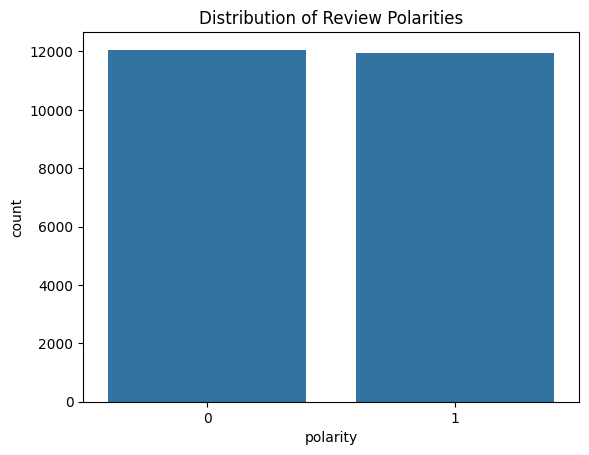

In [11]:
# class counts
print(f"Class Polarity Counts: {amazon_reviews['polarity'].value_counts()}")

# Create countplot of the actual polarity column
sns.countplot(x='polarity', data=amazon_reviews)
plt.title('Distribution of Review Polarities')
plt.show()

> **This plot ensure that our training dataset almost balanced.**

# Data Preparation For Trandformer Models:

## Text Preprocessing:

In [12]:
# function that preprocess the text
def test_preprocessing(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)
    # Convert to lowercase
    text = text.lower()

    # Handle possessive 's (e.g., "god's" → "gods", "john's" → "johns")
    text = re.sub(r"(\w+)'s\b", r"\1s", text)  # Fixed: Adds 's' after the word

    # Fix contractions (e.g., "you're" → "you are")
    text = contractions.fix(text)

    # Remove stray apostrophes (e.g., "dogs'" → "dogs")
    text = re.sub(r"(\w+)'(\s|$)", r"\1 ", text)

    # Remove numbers
    # text = re.sub(r'\d+', '', text)

    # Remove punctuation and special chars (keep words and spaces)
    # text = re.sub(r'[^\w\s]', ' ', text)

    # PROPERLY handle extra spaces:
    # 1. Replace multiple spaces with single space
    # 2. Strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Example
text = "God's plan is great. It's beautiful. Dogs' tails are wagging. I have plan no. 2"
print(test_preprocessing(text))

gods plan is great. its beautiful. dogs tails are wagging. i have plan no. 2



> **Contraction expansion during text preprocessing is generally not recommended when using transformer-based models, as these models are powerful enough to handle contractions like “god's” or “dog's” effectively. Models like BERT use subword tokenization, which can represent such words accurately without needing to expand them.However, since BERT was pre-trained on a very large corpus, it relies on abundant data to learn effective representations. In our case, due to the limited size of our dataset, we may consider expanding contractions to simplify the learning task and help the model generalize better during fine-tuning.**


In [13]:
tqdm.pandas()
# on title column
amazon_reviews['title'] = amazon_reviews['title'].progress_apply(test_preprocessing)
# on review column
amazon_reviews['review'] = amazon_reviews['review'].progress_apply(test_preprocessing)
display(amazon_reviews.head())

100%|██████████| 23998/23998 [00:03<00:00, 6795.69it/s]


,polarity,title,review
0,0,"dull and not classic trek,",i agree on all points with the other 2 star re...
1,1,ronnie should be proud of this effort,this is a solid album. ronnie should be proud ...
2,0,"loud, weak and now broken",i got my haier in march/april of 2011. it was ...
3,1,very good but....,engaging documentary though somehow i cannot h...
4,0,mediocrity redux,"having read the series as a kid, i recently de..."


In [14]:
# Load BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Data loader class for training:

In [15]:
# class that manage the dataset with tokenizer for training
class ReviewDataset(Dataset):
    def __init__(self, titles, reviews, targets, tokenizer, max_len=512, include_raw_text=False):
        self.titles = titles
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.include_raw_text = include_raw_text

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        title = str(self.titles[item])
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            text=title,                # First segment (title)
            text_pair=review,          # Second segment (review)
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt',
            return_overflowing_tokens=False  # 加上这一行

        )

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

        if self.include_raw_text:
            output['title'] = title
            output['review'] = review

        return output

# Function that supplies data batchwise during training
def Create_Dataloader(df, tokenizer, max_len=512, batch_size=16, include_raw_text=False):
    ds = ReviewDataset(
        titles = df['title'].to_numpy(),
        reviews = df['review'].to_numpy(),
        targets = df['polarity'].to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len,
        include_raw_text = include_raw_text
    )
    # Initialize collator (will handle dynamic padding along batch, not depend on whole dataset)
    collator = DataCollatorWithPadding(
        tokenizer=tokenizer,
        padding='longest',  # Pad to longest in batch (up to max_len)
        max_length=max_len  # Safety check
    )
    return DataLoader(ds, batch_size = batch_size, collate_fn = collator, shuffle=True)

Training set shape: (19198, 3)
Validation set shape: (4800, 3)



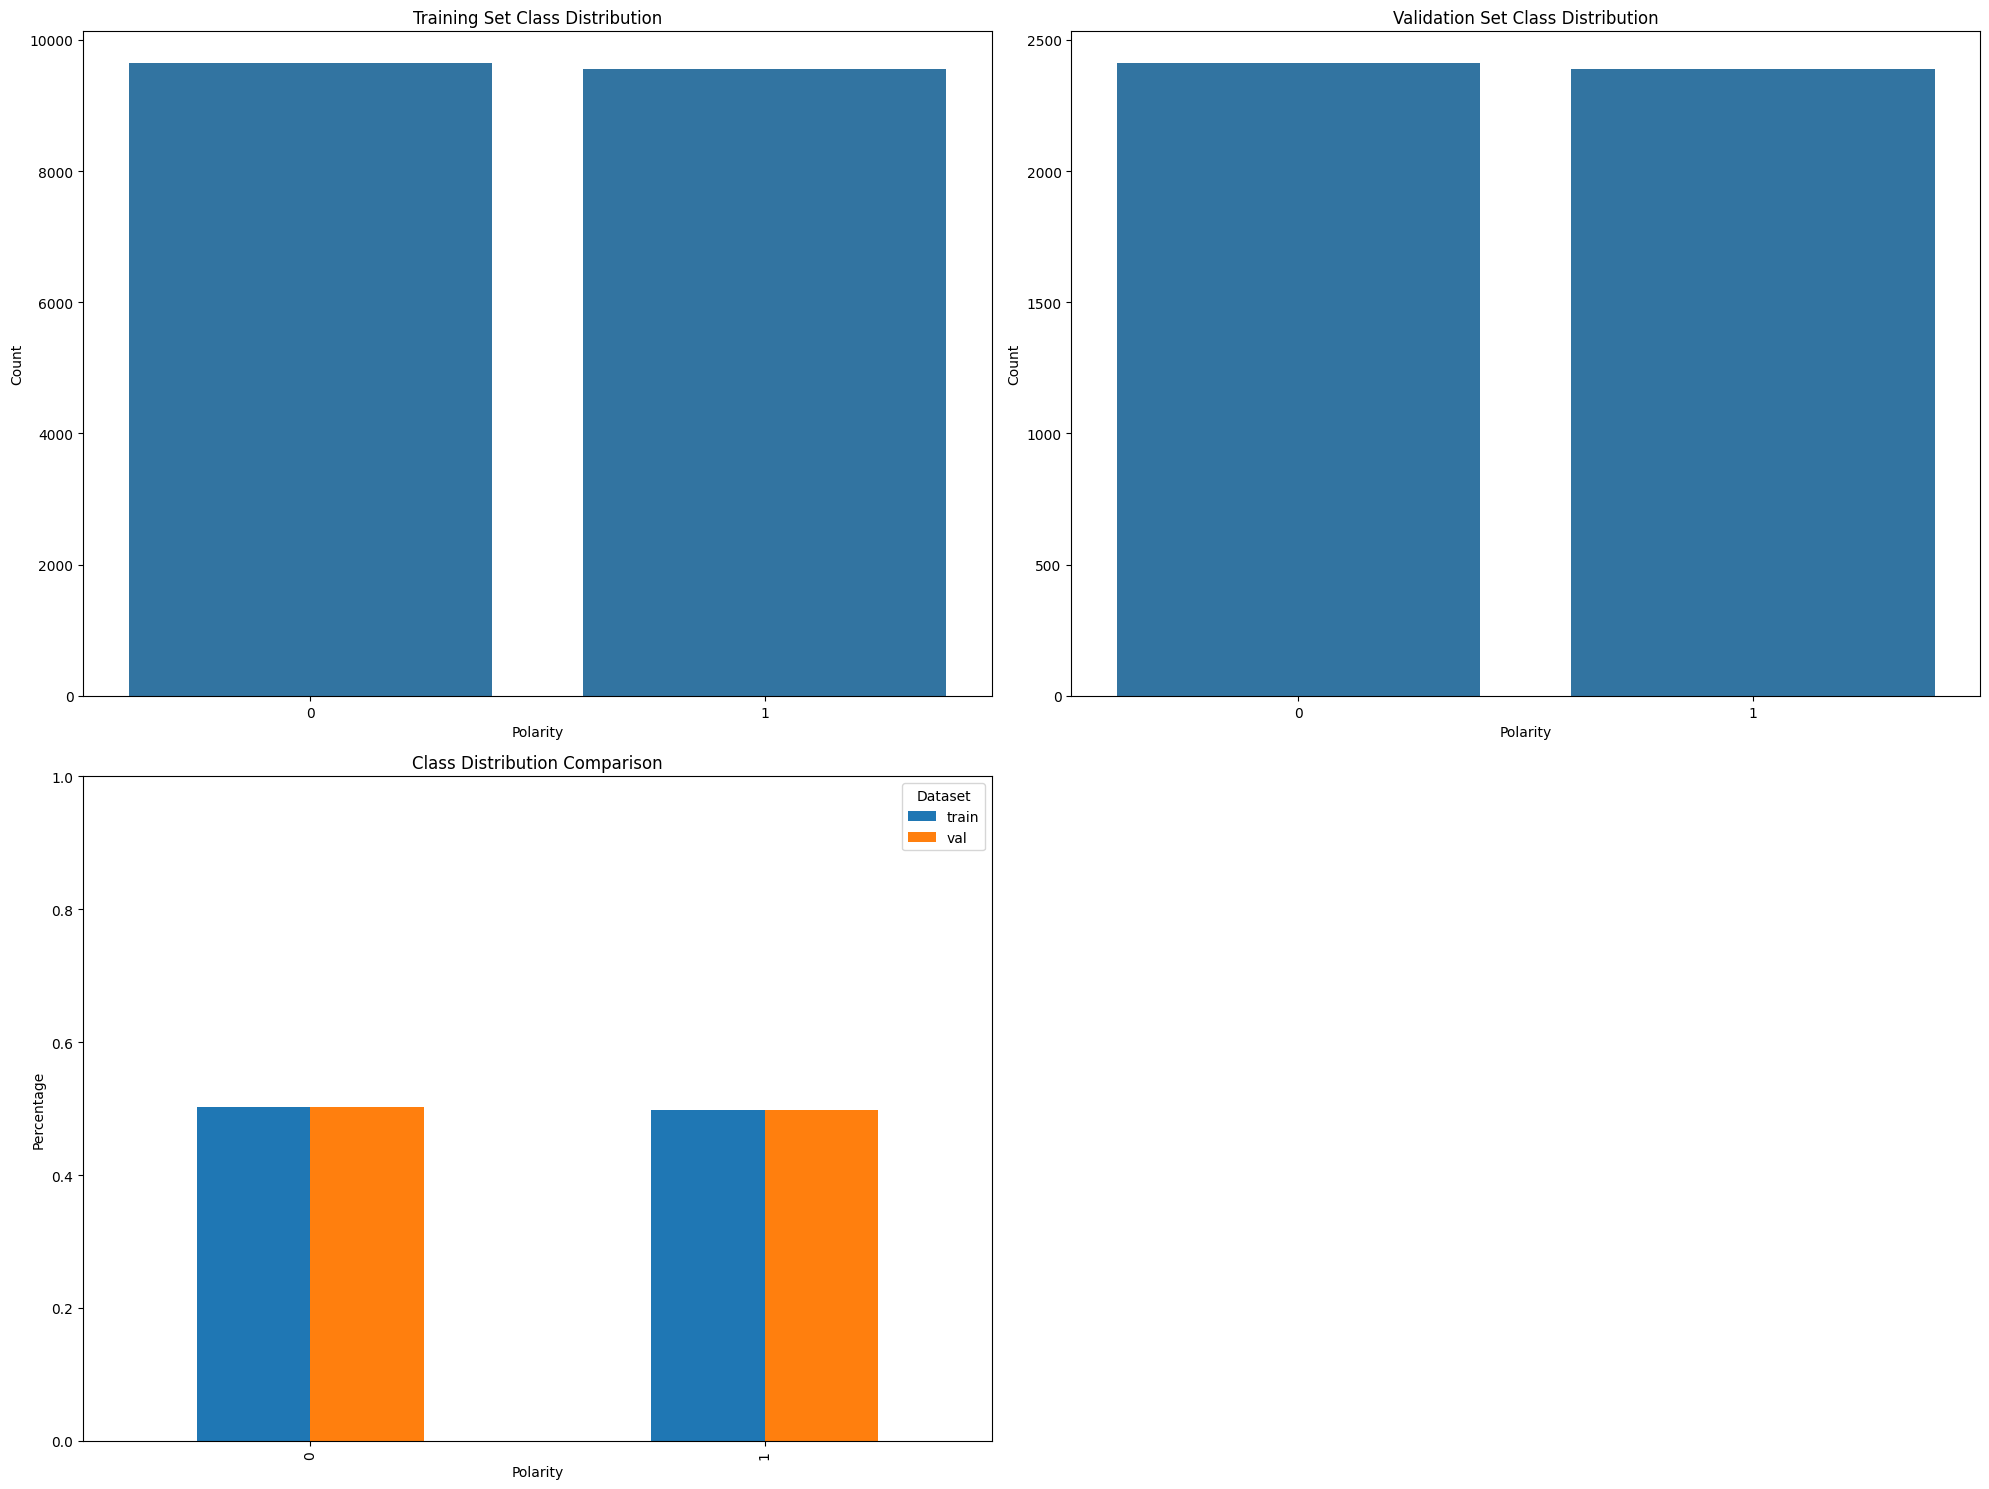

Training set class counts:
polarity
0    9648
1    9550
Name: count, dtype: int64

Validation set class counts:
polarity
0    2412
1    2388
Name: count, dtype: int64


In [16]:
# Perform stratified 80-20% split with shuffling
df_train, df_val = train_test_split(
    amazon_reviews,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=amazon_reviews['polarity']
)

# Print split information
print(f"Training set shape: {df_train.shape}")
print(f"Validation set shape: {df_val.shape}\n")

# Create figure with subplots
plt.figure(figsize=(20, 15))

#Plot 1: Class distribution in training set
plt.subplot(2, 2, 1)
sns.countplot(x='polarity', data=df_train)
plt.title('Training Set Class Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')

#Plot 2: Class distribution in validation set
plt.subplot(2, 2, 2)
sns.countplot(x='polarity', data=df_val)
plt.title('Validation Set Class Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')

#Plot 3: Percentage comparison
plt.subplot(2, 2, 3)
train_pct = df_train['polarity'].value_counts(normalize=True).rename('train')
val_pct = df_val['polarity'].value_counts(normalize=True).rename('val')
pd.concat([train_pct, val_pct], axis=1).plot(kind='bar', stacked=False, ax=plt.gca())
plt.title('Class Distribution Comparison')
plt.xlabel('Polarity')
plt.ylabel('Percentage')
plt.legend(title='Dataset')
plt.ylim(0, 1)


plt.tight_layout()
plt.show()

#Print numerical distribution
print("Training set class counts:")
print(df_train['polarity'].value_counts())
print("\nValidation set class counts:")
print(df_val['polarity'].value_counts())

In [17]:
# train and val data loader
BATCH_SIZE = 16
MAX_LEN = 300     # 512 is recommended but due to storage issue, it is reduced to 300
train_data_loader = Create_Dataloader(df_train, tokenizer=bert_tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)
val_data_loader  = Create_Dataloader(df_val, tokenizer=bert_tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE)

# inspect about the first batch of training data loader
batch = next(iter(train_data_loader))

# Inspect shapes
print(f"Input IDs shape: {batch['input_ids'].shape}")
print(f"Token type ids shape: {batch['token_type_ids'].shape}")
print(f"Attention mask shape: {batch['attention_mask'].shape}")
print(f"Targets shape: {batch['targets'].shape}")

Input IDs shape: torch.Size([16, 202])
Token type ids shape: torch.Size([16, 202])
Attention mask shape: torch.Size([16, 202])
Targets shape: torch.Size([16])


# BERT Model:

In [18]:
# bert pre-trained model
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.config

# freeze bert model
# for layer in bert_model.encoder.layer[:8]:
#     for param in layer.parameters():
#         param.requires_grad = False

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [19]:
# review classifier model
class Amazon_Review_Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Amazon_Review_Classifier, self).__init__()
        # text features extractor (encoder)
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(p=0.5)
        # Enhanced classifier head
        hidden_size = self.bert_model.config.hidden_size
        self.classifier = nn.Sequential(
            # first dense layer
            nn.Linear(hidden_size, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.5),

            # second dense layer
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Dropout(0.3),

            # final dense layer
            nn.Linear(256, n_classes)
        )

        # Initialize weights for the classifier head
        self._init_weights(self.classifier)
    def _init_weights(self, module):
        """Initialize the weights of the classifier head"""
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)

    def forward(self, input_ids, attention_mask, token_type_ids):
        """
        Args:
            input_ids: Tokenized input IDs [batch_size, seq_len]
            attention_mask: Attention mask [batch_size, seq_len]
            token_type_ids: Optional segment IDs [batch_size, seq_len]
        Returns:
            logits: Unnormalized class scores [batch_size, n_classes]
        """
        # features from bert model for classification
        _, pooled_output = self.bert_model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids,
            return_dict=False
        ) # [CLS] token output

        # apply dropout
        output = self.dropout(pooled_output)
        # passes through dense layer
        logits = self.classifier(output)
        # it produces the output of each class
        # they are unnormalized raw prediction
        # of each class
        return logits


In [20]:
# check model utility (whether is it working fine or not?)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Get number of GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")

# Get the name of each GPU
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
# Initialize model
num_classes = 2
model = Amazon_Review_Classifier(num_classes)
# Enable multi-GPU support and move model to GPU
model = nn.DataParallel(model)
model = model.to(device)
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
token_type_ids = batch['token_type_ids'].to(device)

output = model(
    input_ids = input_ids,
    attention_mask = attention_mask,
    token_type_ids = token_type_ids
)

# shape of the output
print(f"Model utility output shape: {output.shape}")

Number of GPUs: 1
GPU 0: NVIDIA A100-SXM4-40GB
Model utility output shape: torch.Size([16, 2])


# Training, Evaluation and Inference Modules:

### Training module:

In [21]:
def train_model(model, data_loader, loss_fn, optimizer, warm_scheduler, n_examples, device):
    """Train the model for one epoch and return average loss and accuracy.

    Args:
        model: The neural network model
        data_loader: DataLoader providing batches of data
        loss_fn: Loss function (e.g., CrossEntropyLoss)
        optimizer: Optimizer (e.g., AdamW)
        warm_scheduler: Warm up scheduler for learning rate
        n_examples: Total number of training examples
        device: Target device (cuda/cpu)

    Returns:
        Tuple of (average_loss, accuracy)
    """
    model.train()  # Set model to training mode
    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader):
        # 1. Inputs Preparation - move all tensors to target device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device)

        # 2. Forward Pass - compute model predictions
        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # 3. Loss Calculation
        loss = loss_fn(logits, targets)
        losses.append(loss.item())

        # 4. Prediction & Accuracy
        _, preds = torch.max(logits, dim=1)  # Get predicted class indices
        correct_predictions += torch.sum(preds == targets).item()

        # 5. Backpropagation
        optimizer.zero_grad()  # Reset gradients before backward pass
        loss.backward()  # Compute gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()  # Update model parameters

        # 6. Learning Rate Scheduling
        if warm_scheduler :
            warm_scheduler.step()  # Update learning rate
    # 7. Calculate epoch metrics
    avg_loss = np.mean(losses)
    accuracy = correct_predictions / n_examples

    return avg_loss, accuracy

## Evaluation Module:

In [22]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    """Evaluate the model on validation/test data.

    Args:
        model: Trained model to evaluate
        data_loader: DataLoader for evaluation data
        loss_fn: Loss function used for training
        device: Target device (cuda/cpu)
        n_examples: Total number of evaluation examples

    Returns:
        Tuple of (average_loss, accuracy)
    """
    model.eval()  # Set model to evaluation mode
    losses = []
    correct_predictions = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in tqdm(data_loader):
            # 1. Prepare batch data
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            token_type_ids = d['token_type_ids'].to(device)
            targets = d['targets'].to(device)


            # 2. Forward pass
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            # 3. Calculate loss
            loss = loss_fn(logits, targets)
            losses.append(loss.item())

            # 4. Get predictions
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == targets).item()

    # 5. Calculate metrics
    avg_loss = np.mean(losses)
    accuracy = correct_predictions / n_examples

    return avg_loss, accuracy

## Inference Module/Get Prediction:

In [23]:
def get_prediction(model, data_loader, device):
    model.eval()  # Set model to evaluation mode

    title_texts = []
    review_texts = []
    predictions = []
    predicted_probs = []
    real_values = []

    with torch.no_grad():  # Disable gradient calculation
        for d in tqdm(data_loader):
            # Extract raw text
            title = d['title']
            review = d['review']

            # Move inputs to device
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            token_type_ids = d['token_type_ids'].to(device)
            targets = d['targets'].to(device)

            # Forward pass
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=1)

            # Get predicted class
            _, preds = torch.max(probs, dim=1)

            # Store results
            title_texts.extend(title)
            review_texts.extend(review)
            predictions.extend(preds.cpu().numpy())
            predicted_probs.extend(probs.cpu().numpy())
            real_values.extend(targets.cpu().numpy())

    return title_texts, review_texts, np.array(predictions), np.array(predicted_probs), np.array(real_values)


# Training Phase

In [24]:
EPOCHS = 10
n_classes = 2  # Binary classification (0/1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Get number of GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")

# Get the name of each GPU
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
# Initialize model
num_classes = 2
model = Amazon_Review_Classifier(num_classes)
# Enable multi-GPU support and move model to GPU
model = nn.DataParallel(model)
model = model.to(device)

# 2. Optimizer Setup (corrected AdamW spelling)
optimizer = torch.optim.AdamW(
    [
        {'params': model.module.bert_model.parameters(), 'lr': 1e-5},  # Lower LR for BERT
        {'params': model.module.classifier.parameters(), 'lr': 1e-3}   # Higher LR for classifier
    ],
    eps=1e-8,           # Numerical stability
    weight_decay=1e-3   # L2 regularization
)

# 3. Calculate Training Steps
total_steps = len(train_data_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)  # 10% warmup

# 4. Learning Rate Scheduler
warmup_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,  # Gradual LR increase
    num_training_steps=total_steps   # Linear decay after warmup
)

plateau_scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',       # Monitor accuracy
    factor=0.1,       # Reduce LR by 10%
    patience=2,       # Wait 2 epochs without improvement
)

# 5. Loss Function
loss_fn = nn.CrossEntropyLoss()

Number of GPUs: 1
GPU 0: NVIDIA A100-SXM4-40GB


In [25]:
# Train the model,
print("Training is underway... please stay tuned!")
history = defaultdict(list)
best_accuracy = 0.0
best_val_loss = float('inf')
num_patience = 3
current_patience = 0
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS} [Training]")

    # Training phase
    train_loss, train_acc = train_model(
        model=model,
        data_loader=train_data_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        warm_scheduler=warmup_scheduler,
        n_examples=len(df_train),
        device=device
    )

    # Validation phase
    print(f"\nEpoch {epoch+1}/{EPOCHS} [Validation]")
    val_loss, val_acc = eval_model(
        model=model,
        data_loader=val_data_loader,
        loss_fn=loss_fn,
        device=device,
        n_examples=len(df_val)
    )

    # Store history
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')  # Use .bin or .pt for PyTorch
        best_accuracy = val_acc
        print(f"New best model saved with accuracy: {best_accuracy:.4f}")
    if best_val_loss > val_loss:
        best_val_loss = val_loss
        current_patience = 0
    else:
        current_patience += 1
        print(f"Training process is in wrong way with patience: {current_patience}/{num_patience}")
        if current_patience >= num_patience:
            print(f"Early stoping at the epoch: {epoch+1}")
            break
    # Plateau scheduling based on validation
    plateau_scheduler.step(val_loss)   # reduce LR on flat region
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")

# Convert history to DataFrame
hist_df = pd.DataFrame(history)
# Start index from 1
hist_df.index = hist_df.index + 1
hist_df.index.name = 'epoch'  # Sets the index label
# Display the DataFrame
display(hist_df)

# Save to CSV
hist_df.to_csv("./Training_history.csv", index=True, index_label="epoch")



Training is underway... please stay tuned!

Epoch 1/10 [Training]


100%|██████████| 1200/1200 [02:35<00:00,  7.70it/s]



Epoch 1/10 [Validation]


100%|██████████| 300/300 [00:20<00:00, 14.35it/s]


New best model saved with accuracy: 0.9321
Train Loss: 0.4067 | Accuracy: 0.7963 | Val Loss: 0.2094 | Accuracy: 0.9321

Epoch 2/10 [Training]


100%|██████████| 1200/1200 [02:35<00:00,  7.72it/s]



Epoch 2/10 [Validation]


100%|██████████| 300/300 [00:20<00:00, 14.33it/s]


New best model saved with accuracy: 0.9373
Training process is in wrong way with patience: 1/3
Train Loss: 0.1944 | Accuracy: 0.9448 | Val Loss: 0.2102 | Accuracy: 0.9373

Epoch 3/10 [Training]


100%|██████████| 1200/1200 [02:35<00:00,  7.73it/s]



Epoch 3/10 [Validation]


100%|██████████| 300/300 [00:20<00:00, 14.42it/s]


Training process is in wrong way with patience: 2/3
Train Loss: 0.1247 | Accuracy: 0.9718 | Val Loss: 0.3456 | Accuracy: 0.9340

Epoch 4/10 [Training]


100%|██████████| 1200/1200 [02:35<00:00,  7.72it/s]



Epoch 4/10 [Validation]


100%|██████████| 300/300 [00:20<00:00, 14.43it/s]

Training process is in wrong way with patience: 3/3
Early stoping at the epoch: 4


,train_acc,train_loss,val_acc,val_loss
epoch,,,,
1,0.796281,0.406680,0.932083,0.209395
2,0.944838,0.194431,0.937292,0.210227
3,0.971768,0.124722,0.933958,0.345606
4,0.985728,0.074722,0.935833,0.378719


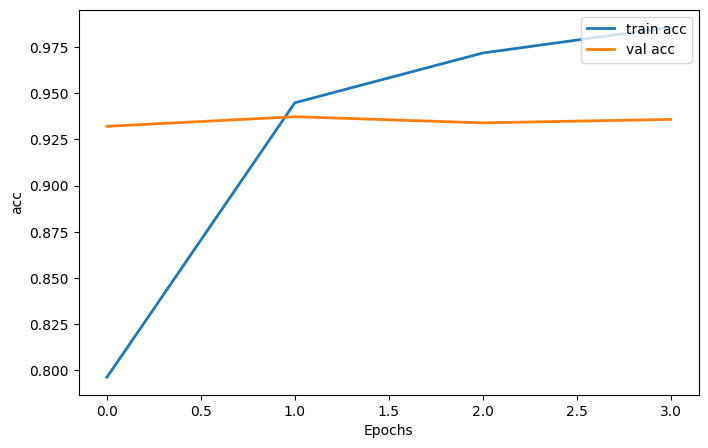

In [30]:
#acc plot
plt.figure(figsize=(8, 5))
plt.plot(history["train_acc"], label='train acc', linewidth=2)
plt.plot(history["val_acc"], label='val acc', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.ylim()
plt.legend(loc = 'upper right')

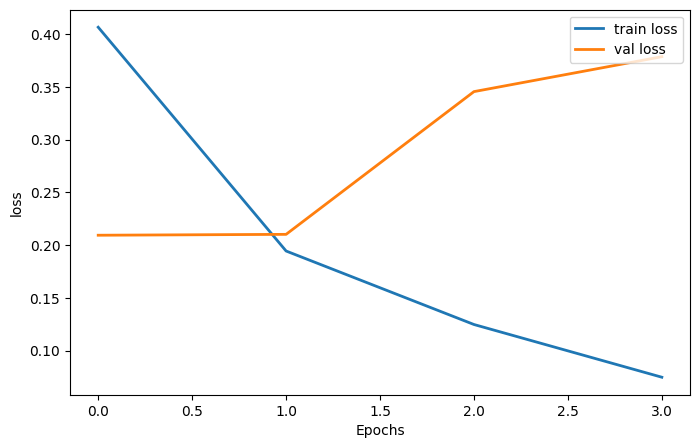

In [31]:
#Loss plot
plt.figure(figsize=(8, 5))
plt.plot(history["train_loss"], label='train loss', linewidth=2)
plt.plot(history["val_loss"], label='val loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.ylim()
plt.legend(loc = 'upper right')

# Performance on test set:

> **Take 1% data from remaining (out of tarining+validation data) data and check the model performance on them.**

Model is working on test set....


100%|██████████| 1488/1488 [01:44<00:00, 14.23it/s]


Testing has been done!
Prediction result on test set has been set as Results_on_testset.csv


,title,review,true_label,predicted_label
0,not as good as the TV series (2.5/5),"though i thought this movie was OK,in my opini...",0,0
1,You will never encounter huge ships again,Easily the best huge ship avoidance educationa...,1,1
2,"Bought, Returned, Bought, Returned-Garbage",Let me be brief. I bought this unti 2X because...,0,0
3,frustrating,This product must be applied to back of the pu...,0,0
4,Not worth the money,I do not suggest buying this book unless you k...,0,0
5,Easy But Not Perfect,This transmitter is easy to use and works well...,1,1
6,Another contraption ....,"Although this thermometer works, I find it to ...",0,0
7,What a dissapointment!,Man I wanted to really see this movie when I s...,0,0
8,Price is right,I have taken quite a few pictures with this ca...,1,1
9,The Last Promise,"Good, enjoyable book. I hadn't read anything b...",1,1



 Test Set Accuracy: 0.9398

 Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.93      0.94     11938
    Positive       0.93      0.95      0.94     11869

    accuracy                           0.94     23807
   macro avg       0.94      0.94      0.94     23807
weighted avg       0.94      0.94      0.94     23807


 Confusion Matrix:
[[11119   819]
 [  615 11254]]


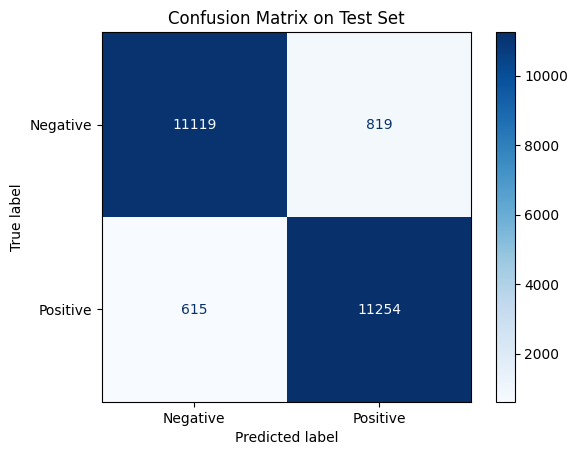

In [32]:
class ReviewDataset(Dataset):
    def __init__(self, titles, reviews, targets, tokenizer, max_len=512, include_raw_text=False):
        self.titles = titles
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.include_raw_text = include_raw_text

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        title = self.titles[item]  # No need to cast to str if already a string
        review = self.reviews[item]  # No need to cast to str if already a string
        target = self.targets[item]

        # Ensure title and review are strings
        if not isinstance(title, str):
            title = str(title)
        if not isinstance(review, str):
            review = str(review)

        # Tokenize the inputs (title and review)
        encoding = self.tokenizer.encode_plus(
            text=title,                # First segment (title)
            text_pair=review,          # Second segment (review)
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_overflowing_tokens=False,
            return_tensors='pt'
        )

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

        # Optionally include the raw text (title and review)
        if self.include_raw_text:
            output['title'] = title
            output['review'] = review

        return output


# Function that supplies data batchwise during training
def Create_Dataloader(df, tokenizer, max_len=512, batch_size=16, include_raw_text=False):
    ds = ReviewDataset(
        titles = df['title'].to_numpy(),
        reviews = df['review'].to_numpy(),
        targets = df['polarity'].to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len,
        include_raw_text = include_raw_text
    )
    # # Initialize collator (will handle dynamic padding along batch, not depend on w)
    # collator = DataCollatorWithPadding(
    #     tokenizer=tokenizer,
    #     padding='longest',  # Pad to longest in batch (up to max_len)
    #     max_length=max_len  # Safety check
    # )
    def custom_collate_fn(batch):
        # Separate raw text and model inputs
        raw_titles = [item['title'] for item in batch]
        raw_reviews = [item['review'] for item in batch]

        # Remove raw fields for padding
        for item in batch:
            item.pop('title')
            item.pop('review')

        # Use tokenizer's padding
        padded_batch = bert_tokenizer.pad(
            batch,
            padding='longest',
            return_tensors='pt'
        )

        # Optionally include raw fields again
        padded_batch['title'] = raw_titles
        padded_batch['review'] = raw_reviews
        return padded_batch

    return DataLoader(ds, batch_size = batch_size, collate_fn = custom_collate_fn, shuffle=True)

# create the test data
amazon_test_reviews = amazon_reviews_0.drop(amazon_reviews.index,errors='ignore').reset_index(drop=True)
amazon_test_reviews.columns = ['polarity','title','review']
# amazon_test_reviews['polarity'] = amazon_test_reviews['polarity'].apply(lambda x: 0 if x <= 3 else 1)
# test data loader creation
MAX_LEN = 300
BATCH_SIZE = 16
num_classes = 2
test_data_loader = Create_Dataloader(
    amazon_test_reviews.sample(frac=0.01, random_state=42),
    tokenizer=bert_tokenizer,
    max_len=MAX_LEN,
    batch_size=BATCH_SIZE,
    include_raw_text = True
)
# initialize the model and load its saved weights
best_model = Amazon_Review_Classifier(num_classes)
# Enable multi-GPU support and move model to GPU
best_model = nn.DataParallel(best_model)
best_model = best_model.to(device)
best_model.load_state_dict(torch.load('best_model_state.bin',weights_only=True, map_location=device))
print("Model is working on test set....")
title_texts, review_texts, predictions, predicted_probs, real_values = get_prediction(
    model=best_model,
    data_loader=test_data_loader,
    device=device
)
print("Testing has been done!")

results_df = pd.DataFrame({
    'title': title_texts,
    'review': review_texts,
    'true_label': real_values,
    'predicted_label': predictions
})
# save as data frame
results_df.to_csv("./Results_on_testset.csv")
print("Prediction result on test set has been set as Results_on_testset.csv")
display(results_df.head(50))

# accuracy on test sets
accuracy = accuracy_score(results_df['true_label'], results_df['predicted_label'])
print(f"\n Test Set Accuracy: {accuracy:.4f}")

# print classification report including precision, recall, f1-score）
print("\n Classification Report:")
print(classification_report(results_df['true_label'], results_df['predicted_label'], target_names=["Negative", "Positive"]))

# compute and print confusion Matrix
cm = confusion_matrix(results_df['true_label'], results_df['predicted_label'])
print("\n Confusion Matrix:")
print(cm)

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()